In [78]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import branca
from branca.colormap import linear
from branca.element import MacroElement
from branca.colormap import LinearColormap
from jinja2 import Template
import json
import base64
from folium import plugins

In [83]:
dfmain = pd.read_csv('data2.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


a


RecursionError: maximum recursion depth exceeded in comparison

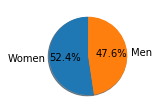

In [84]:
m = folium.Map(
    location=[0, 0],
    zoom_start=3)
fgdict = {}

def geojson(LH, file, df):
    gdata = json.load(open(file))
    df = df[df["Frequency"] == "Monthly"][df["LocationHierarchy"] == LH]
    df = df[['Location', 'venezuelans', 'ven/pop', 'KML']]
    df.rename(columns={'ven/pop':'proportion'}, inplace=True)
    fgdict[LH] = folium.map.FeatureGroup(name=LH, show=False)

    colormap = LinearColormap(['green', 'yellow', 'orange','red'],vmin=df.venezuelans.min(),vmax=df.venezuelans.max()).to_step(data=df.venezuelans, n=9, method='quantiles')
    colormap.caption = 'Absolute Measure'
    colormap2=LinearColormap(['green', 'yellow', 'orange','red'],vmin=df.proportion.min(),vmax=df.proportion.max()).to_step(data=df.proportion, n=9, method='quantiles')
    colormap2.caption = 'Relative Measure'
    m.add_child(colormap)
    m.add_child(colormap2)
    m.add_child(BindColormap(fgdict[LH], colormap)).add_child(BindColormap(fgdict[LH], colormap2))

    vdict = df.set_index('Location')['venezuelans']
    vdict2 = df.set_index('Location')['proportion']
    folium.GeoJson(gdata,
           style_function=lambda feature: {
          'fillColor': colormap(vdict[feature['properties']['name']]) if feature['properties']['name'] in vdict else 'grey',
          'color': colormap2(vdict2[feature['properties']['name']]) if feature['properties']['name'] in vdict2 else 'grey',
          'weight': 2,
          'fillOpacity': 1 if feature['properties']['name'] in vdict else 0} ).add_to(fgdict[LH])
    for feature in gdata['features']:
        geo = folium.GeoJson(feature['geometry'],
           style_function=lambda feature: {
           'weight': 0,
           'fillOpacity': 0},
            tooltip =feature['properties']['name'])
        geo.add_to(fgdict[LH])
    fgdict[LH].add_to(m)
  
geojson("City", 'city3.0.geojson', dfmain)
fgdict["None"] = folium.map.FeatureGroup(name="Non", show=False)
fgdict["None"].add_to(m)

#facts

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

fgfacts = {}
def facts(LH, dfm):
    fgfacts[LH] = folium.map.FeatureGroup(name='Facts for ' + LH, show = False)
    Loc, tdict, pdict, pidict, hdict, cdict = [], {}, {}, {}, {}, {}
    df = dfm
    df = df[df['Frequency']=='Monthly'][df['LocationHierarchy']==LH]
    def cfacts(array, labels, icon):
      print("a")
      for i in range(len(array)):
        arr = [0]*len(array)
        a = df.loc[df[array[i]].idxmax(axis=1)]
        for j in range(len(array)):
            arr[j]=a[array[j]]
        fig1, ax1 = plt.subplots(figsize=(1.8,1.8))
        ax1.pie(arr, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
        plt.savefig('myfig.png', transparent = True)
        html1 = '<center><img align="middle" src="data:image/png;base64,{}"></center>'
        encoded = base64.b64encode(open(icon, 'rb').read()).decode()
        encpie = base64.b64encode(open('myfig.png', 'rb').read()).decode()
        ic = '2.png'
        l = a.Location
        if l not in Loc:
          Loc.append(l)
          pdict[l], hdict[l],tdict[l], pidict[l], cdict[l] = '<h4><center>' + l +'</center></h4>', '', [], [], 0
        pdict[l] += '<hr><center><p style="padding:0px 10px 0px 10px">'+ l
        hdict[l] += html1
        tdict[l].append(encoded)
        pidict[l].append(encpie)
        cdict[l]+=1
        string = " highest percentage of "+ labels[i]+"."
        pdict[l] += ' has the'+string+'</p></center><center><img align="middle" src="data:image/png;base64,{}"></center>' 
        iframe = branca.element.IFrame(html=pdict[l].format(*pidict[l]), width=400, height = 220 + cdict[l]* 50)
        folium.Marker([a.LatLong.split(",")[0], a.LatLong.split(",")[1]], popup = folium.Popup(iframe), icon = folium.features.CustomIcon(ic,icon_size=(28, 30)),tooltip=hdict[l].format(*tdict[l]) ).add_to(fgfacts[LH])

    cfacts(['%ven_audience_woman', '%ven_audience_man'], ('Women', 'Men'), '2.png')
    cfacts(['%ven_audience_iOS', '%ven_audience_Android', '%ven_audience_Other'], ('iOS', 'Android', 'Other'), '2.png')
    cfacts(['%ven_audience_graduated', '%ven_audience_high_school','%ven_audience_no_degree'], ('Graduated', 'High School', 'No degree'), '2.png')
    cfacts(['%ven_audience_single', '%ven_audience_dating', '%ven_audience_married'], ('Single', 'Dating', 'Married'), '2.png')
    fgfacts[LH].add_to(m)

facts("City", dfmain)
fgfacts["None"] = folium.map.FeatureGroup(name="Non", show = False)
fgfacts["None"].add_to(m)

folium.plugins.GroupedLayerControl({}, 
                                    {'Location Hierarchy' : {'Cities' : fgdict["City"], "None " : fgdict["None"]},
                                    'Facts': {"Cities" : fgfacts["City"], "None " : fgfacts["None"]}}, 
                                  ['Location Hierarchy', 'Facts']).add_to(m)

In [77]:
m.save('Citymap-1.html')